# Taxi Trajectory Prediction
## Graham Daley
## DS5, 2015

https://www.kaggle.com/c/pkdd-15-predict-taxi-service-trajectory-i

From the text in the introduction:

Electronic dispatch systems make it easy to see where a taxi has been, but not necessarily where it is going. In most cases, taxi drivers operating with an electronic dispatch system do not indicate the final destination of their current ride. Since taxis using electronic dispatch systems do not usually enter their drop off location, it is extremely difficult for dispatchers to know which taxi to contact. To improve the efficiency of electronic taxi dispatching systems it is important to be able to predict the final destination of a taxi while it is in service. The requirement is to build a predictive framework that is able to infer the final destination of taxi rides in Porto, Portugal based on their (initial) partial trajectories. The output of such a framework must be the final trip's destination (WGS84 coordinates).

[My Keynote Presentation](https://www.dropbox.com/s/cocllmjv9k80x2c/gdaley-taxi-trajectory-project.key?dl=0)

## 1) Exploration

### Preliminaries

In [1]:
# Gratuitously copied from Mr van de Ven's class notes
%matplotlib inline
from __future__ import unicode_literals, division

import json
import folium
import numpy as np
import pandas as pd
import seaborn as sns
import IPython
import matplotlib as mpl
import matplotlib.pyplot as plt

from random import randint
from random import sample
from pylab import *
from IPython.display import HTML
from IPython.display import display as prnt

# Local data directory
DATA_DIR = "../data/project/"

# Notebook Options
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True)

# Matplotlib Styles
c = {'axes.labelsize': 17,
'axes.titlesize': 16,
'figure.figsize': [18, 8],
'grid.linewidth': 1.6,
'legend.fontsize': 17,
'lines.linewidth': 2,
'lines.markeredgewidth': 0.0,
'lines.markersize': 11,
'patch.linewidth': 0.5,
'xtick.labelsize': 16,
'xtick.major.pad': 20,
'xtick.major.width': 2,
'xtick.minor.width': 1,
'ytick.labelsize': 16.0,
'ytick.major.pad': 20,
'ytick.major.width': 2,
'ytick.minor.width': 1 }
wide_c = dict(c, **{'figure.figsize':[20,8]})

def table(df,replace_match="",replace_str=""):
    return IPython.display.display(HTML(df.to_html().replace('<table border="1" class="dataframe">','<table class="table table-striped table-hover">').replace(replace_match,replace_str)))

### Load and Inspect the Data

In [2]:
train_data = pd.read_csv(DATA_DIR + "train.csv")
train_data = train_data[train_data['MISSING_DATA'] == False]
train_data['POINTS'] = map(lambda polyline: polyline.count("]") - 1, train_data['POLYLINE'])
train_data = train_data[train_data['POINTS'] > 1]
train_data.drop('MISSING_DATA', axis=1, inplace=True)
train_data.drop('DAY_TYPE', axis=1, inplace=True)
table(train_data.head(5))

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,POLYLINE,POINTS
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",23
1,1372637303620000596,B,NaN,7,20000596,1372637303,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",19
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",65
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",43
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",29


In [3]:
table(train_data.describe())

,TRIP_ID,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,POINTS
count,1.674152e+06,362716.000000,797686.000000,1674152.000000,1.674152e+06,1674152.000000
mean,-2.587451e+12,24492.082679,30.250048,20000349.373243,1.388600e+09,49.803011
std,9.191946e+15,19624.567796,17.736708,210.891072,9.191946e+06,45.589535
min,1.372637e+18,2001.000000,1.000000,20000001.000000,1.372637e+09,2.000000
25%,1.380707e+18,6598.000000,15.000000,20000167.000000,1.380707e+09,29.000000
50%,1.388440e+18,18755.000000,27.000000,20000345.000000,1.388440e+09,42.000000
75%,1.396749e+18,40809.250000,49.000000,20000520.000000,1.396749e+09,59.000000
max,1.404173e+18,63884.000000,63.000000,20000981.000000,1.404173e+09,3881.000000


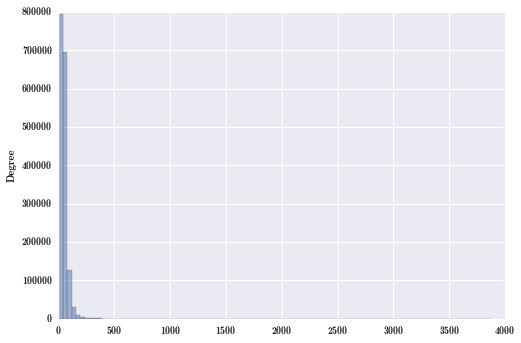

In [4]:
train_data["POINTS"].plot(kind='hist', alpha=0.5, bins=100);

In [5]:
train_data.CALL_TYPE.value_counts()

B    808889
C    502547
A    362716
dtype: int64

### Univariate

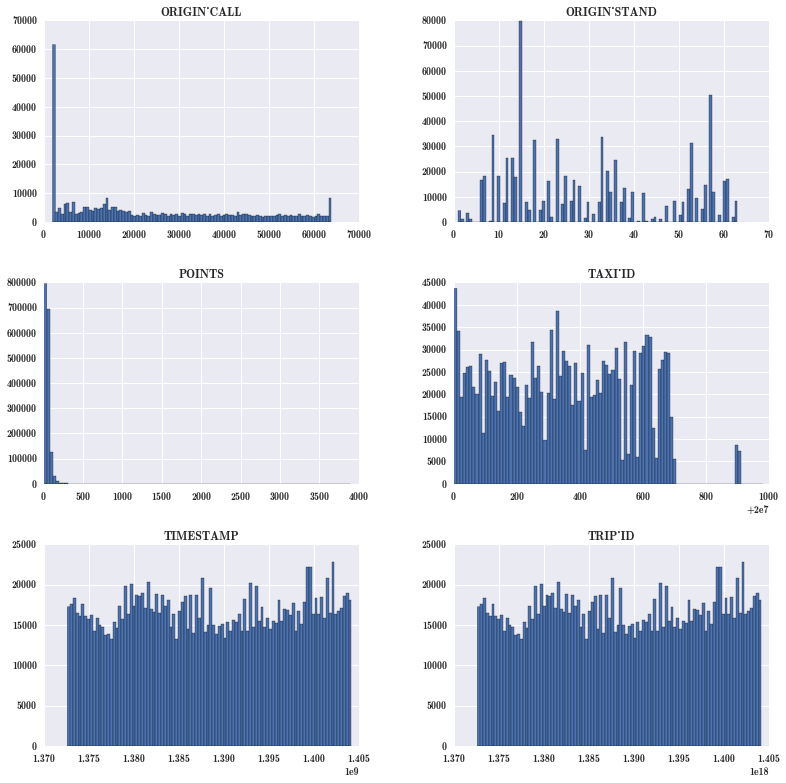

In [6]:
train_data.hist(figsize=(13,13), bins=100);

### Multivariate

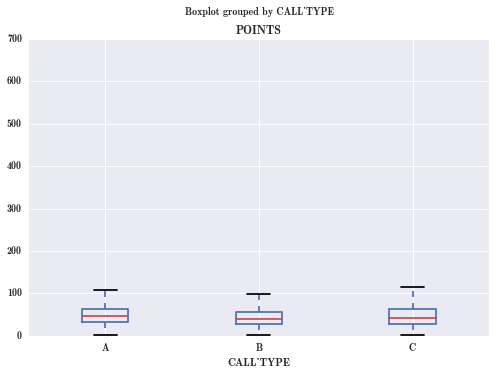

In [7]:
train_data[train_data['POINTS'] < 613].boxplot(column='POINTS', by='CALL_TYPE');

The CALL_TYPE field does not seem to show any significant relationship to the length of trips taken.

In [8]:
test_data = pd.read_csv(DATA_DIR + "test.csv")
test_data['POINTS'] = map(lambda polyline: polyline.count("]") - 1, test_data["POLYLINE"])
test_data.drop('MISSING_DATA', axis=1, inplace=True)
test_data.drop('DAY_TYPE', axis=1, inplace=True)
table(test_data.describe())

,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,POINTS
count,72.000000,123.000000,320.000000,3.200000e+02,320.000000
mean,38074.083333,29.991870,20000353.587500,1.412465e+09,45.118750
std,28528.026167,18.444198,206.535355,3.144882e+06,66.739927
min,2002.000000,1.000000,20000004.000000,1.408032e+09,1.000000
25%,9159.500000,15.000000,20000175.500000,1.412064e+09,14.000000
50%,36879.500000,23.000000,20000351.500000,1.412616e+09,26.500000
75%,65548.250000,49.000000,20000517.250000,1.414814e+09,48.000000
max,86436.000000,63.000000,20000904.000000,1.419172e+09,612.000000


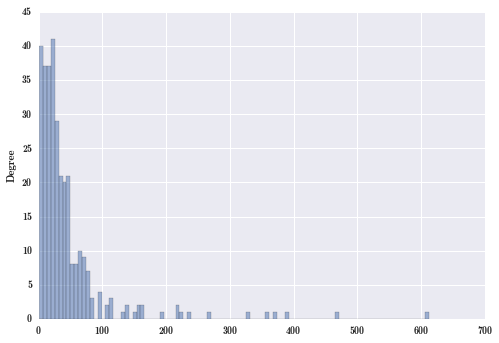

In [9]:
test_data["POINTS"].plot(kind='hist', alpha=0.5, bins=100);

The trips in the test data seem to be shorter than many of those in the training data.

### Visualising the Routes

In [10]:
def display(m, height=1000):
    """Takes a folium instance and embeds in HTML."""
    m._build_map()
    srcdoc = m.HTML.replace('"', '&quot;')
    embed = HTML('<iframe srcdoc="{0}" '
                 'style="width: 100%; height: {1}px; '
                 'border: none"></iframe>'.format(srcdoc, height))
    return embed

map_osm = folium.Map(location=[41.1579438, -8.629105299999992],
                    zoom_start=13)

# Plot 3 randomly-chosen routes on a map of the city
for t in range(3):
    trip = randint(0, 1674152)
    polyline = json.loads(train_data.loc[trip, "POLYLINE"])
    for i, pt in enumerate(polyline):
        if i == 0:
            # Starting point in green
            lcolor = '#00FF00'
            fcolor = '#11FF11'
            radius = 100
        elif i == len(polyline) - 1:
            # End point in red
            lcolor = '#FF0000'
            fcolor = '#FF1111'
            radius = 100
        else:
            lcolor = '#000000'
            fcolor = '#000000'
            radius = 30
        map_osm.circle_marker(location=[pt[1], pt[0]], radius=radius,
                              line_color=lcolor,
                              fill_color=fcolor, fill_opacity=0.5)

map_osm.create_map(path='osm.html')
display(map_osm, height=500)

## Initial thoughts

Having looked at the overall structure of the training and test data, the following points come to mind initially:

* The duration of the (partial) journey could be estimated by the number of points x 15 seconds.

* The DAY_TYPE column is always 'A', in both training and testing data sets. According to [one of the messages on the Kaggle forum](https://www.kaggle.com/c/pkdd-15-predict-taxi-service-trajectory-i/forums/t/14299/observations-on-the-data/79288#post79288) the data in this column is probably incorrect, and can be replaced by publicly-available holiday information.

* The polyline point coordinates should be separated into individual features, however the trips do not all have an identical number of points specified.

* The number of polyline points for the trips in the training data ranges from 0 to 3,881. Test data points range from 1 to 612. It might make sense to limit the number of points used in the model when training.

* The total distance travelled could be calculated using the haversine formula (below) by comparing the 1st point in the polyline with the last one.

* There are 30,607 rows in the training data that only have 1 point in the polyline and 5,901 rows with no points at all. These may represent extremely short journeys of less than 30 seconds in duration. As they contain insufficient information, they are of no use for training a model, so can be removed.

* There are approximately 14,000 rows containing "trips" which lasted over 2.5 minutes but did not even travel 50m from the starting point. These are likely to be cases where the GPS (error) continued to register movement of the car even though it was actually stationary at the time.

* [The competition rules](http://www.geolink.pt/ecmlpkdd2015-challenge/rules.html) state that no external data may be used in the model apart from weather-based data (e.g. weather forecasts). It may be worth adding weather-related features into the model, such as "is raining", as it is common knowledge that, in some parts of the world, this affects taxi usage.

* Call type 'A' has some additional information associated with it – a unique identifier of the caller. It might be worthwhile having a separate model for these calls, which takes this into consideration.

## Transforming the Data

We will now take the training and test data sets, and transform some of the features to produce ones that should, hopefully, result in a model that can predict the destination of the taxi.

The first area to be addressed will be the DAY_TYPE field, as this appears to be incorrect in the data supplied.

Following this, we will transform the polyline string into a "standardised" set of 3 points along the line of travel – beginning, middle and end. We will also determine the distance, average speed and general direction of each segment of the trip.

In [ ]:
# Fetch public holiday dates in 2013 & 2014
import datetime
from lxml.html import parse

URL_BASE = 'http://www.officeholidays.com/countries/portugal/'
years = [2013, 2014]
holidays = []
for year in years:
    url = "{0}{1}.php".format(URL_BASE, year)
    doc = parse(url).getroot()
    for div in doc.cssselect('tr.holiday span.mobile_ad'):
        date_str = "{0} {1}".format(div.text_content(), year)
        print date_str
        date = datetime.datetime.strptime(date_str, '%b %d %Y').date()
        holidays.append(date)

In [3]:
from math import radians, degrees, cos, sin, asin, atan2, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    From StackOverflow: http://bit.ly/1bKauqS
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat / 2.0)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2.0)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometres.
    return c * r

def compass_bearing(lon1, lat1, lon2, lat2):
    """
    Calculate the compass bearing between two points on the earth
    (specified in decimal degrees)
    Returns compass bearing in degrees
    Adapted from: http://www.movable-type.co.uk/scripts/latlong.html
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    bearing_rad = atan2(cos(lat1) * sin(lat2) - sin(lat1) * cos(lat2) * cos(lon2 - lon1),
                        sin(lon2 - lon1) * cos(lat2))
    return (degrees(bearing_rad) + 360) % 360

def today_is_holiday(date):
    return date in holidays

def tomorrow_is_holiday(date):
    tomorrow = date + datetime.timedelta(days=1)
    return tomorrow in holidays

def day_type(timestamp):
    """
    Lookup the given date in the 2013 and 2014 lists of public holidays in Portugal.
    Return '1' for public holidays, '2' for days before a '1' day, and '0' for all other days.
    """
    date = datetime.datetime.utcfromtimestamp(timestamp).date()
    if today_is_holiday(date):
        return 1
    elif tomorrow_is_holiday(date):
        return 2
    else:
        return 0
    
def period_of_day(timestamp):
    """
    Given a unix timestamp value, return a value between 0 - 3,
    representing the current 6-hour period of the day, to approximate
    morning, afternoon, evening and night.
    """
    dtime = datetime.datetime.utcfromtimestamp(timestamp).time()
    return int(dtime.hour / 6)

In [4]:
import csv

def transform_dataset(filename, is_test=False):
    """
    Transform the given dataset to create features from some of the points
    in the poly line.
    """
    in_filename = "{0}{1}.csv".format(DATA_DIR, filename)
    out_filename = "{0}{1}_transformed.csv".format(DATA_DIR, filename)
    field_names = ["DAY_TYPE", "DAY_PERIOD", "POINTS",
                   "LON_S", "LAT_S", "LON_M", "LAT_M", "LON_E", "LAT_E",
                   "DISTANCE", "AVSPEED", "AVBEARING",
                   "DISTANCE_SM", "AVSPEED_SM", "AVBEARING_SM",
                   "DISTANCE_ME", "AVSPEED_ME", "AVBEARING_ME",
                   "LON_F", "LAT_F"]
    if is_test:
        field_names.remove("LON_F")
        field_names.remove("LAT_F")

    with open(out_filename, "wb") as out_file:
        csv_writer = csv.DictWriter(out_file, fieldnames=field_names)
        csv_writer.writeheader()
        with open(in_filename) as in_file:
            csv_reader = csv.DictReader(in_file)
            
            for line in csv_reader:
                if line["MISSING_DATA"] == "False":
                    
                    # Doing this conversion line-by-line mostly because converting all of the polylines
                    # in the data set to arrays would take up too much memory (>16GB).
                    polyline = json.loads(line["POLYLINE"])
                    polylen = len(polyline)
                    if polylen > 1 or is_test == True:
                        
                        # Truncate the polyline if it contains more than 612 + 1 points
                        if is_test == False and polylen > 613:
                            polyline = polyline[:613]
                            
                        # Create features to describe a standardised polyline of 3 points –
                        # start, middle and end.
                        line["LON_S"] = polyline[0][0]
                        line["LAT_S"] = polyline[0][1]
                        
                        # Find the mid point and end point
                        # (Don't count the last point in training data as this is the destination)
                        subtr = 0 if is_test else 1
                        midpoint = int(polylen / 2) - (1 + subtr)
                        endpoint = polylen - (1 + subtr)
                        
                        try:
                            line["LON_M"] = polyline[midpoint][0]
                            line["LAT_M"] = polyline[midpoint][1]
                        except:
                            line["LON_M"] = line["LON_S"]
                            line["LAT_M"] = line["LAT_S"]
                            
                        try:
                            line["LON_E"] = polyline[endpoint][0]
                            line["LAT_E"] = polyline[endpoint][1]
                        except:
                            line["LON_E"] = line["LON_S"]
                            line["LAT_E"] = line["LAT_S"]
                            
                        # Add distances travelled, average speeds and compass bearings between each point
                        line["DISTANCE"] = haversine(line["LON_S"], line["LAT_S"], line["LON_E"], line["LAT_E"])
                        line["AVSPEED"] = line["DISTANCE"] / (15 * (polylen - subtr)) if polylen > subtr else 0.0
                        line["AVBEARING"] = compass_bearing(line["LON_S"], line["LAT_S"],
                                                               line["LON_E"], line["LAT_E"])

                        line["DISTANCE_SM"] = haversine(line["LON_S"], line["LAT_S"], line["LON_M"], line["LAT_M"])
                        line["AVSPEED_SM"] = line["DISTANCE_SM"] / (15 * midpoint) if midpoint > 0 else 0.0
                        line["AVBEARING_SM"] = compass_bearing(line["LON_S"], line["LAT_S"],
                                                               line["LON_M"], line["LAT_M"])
                        
                        line["DISTANCE_ME"] = haversine(line["LON_M"], line["LAT_M"], line["LON_E"], line["LAT_E"])
                        line["AVSPEED_ME"] = line["DISTANCE_ME"] / (15 * midpoint) if midpoint > 0 else 0.0
                        line["AVBEARING_ME"] = compass_bearing(line["LON_M"], line["LAT_M"],
                                                               line["LON_E"], line["LAT_E"])
                        
                        if is_test == False:
                            try:
                                line["LON_F"] = polyline[-1][0]
                                line["LAT_F"] = polyline[-1][1]
                            except:
                                continue
                            
                        line["DAY_TYPE"] = day_type(float(line["TIMESTAMP"]))
                        line["DAY_PERIOD"] = period_of_day(float(line["TIMESTAMP"]))
                        line["POINTS"] = polylen - subtr
                        
                        # Remove any features that we will not use for now
                        del line["CALL_TYPE"]
                        del line["ORIGIN_CALL"]
                        del line["ORIGIN_STAND"]
                        del line["TAXI_ID"]
                        del line["TIMESTAMP"]
                        del line["POLYLINE"]
                        del line["TRIP_ID"]
                        del line["MISSING_DATA"]
                        csv_writer.writerow(line)
                
transform_dataset("train")
transform_dataset("test", is_test=True)

## Analysis

### Load Training Data

In [5]:
def get_dataset():
    """
    Reads the training dataset, removes some unused rows / columns
    """
    df = pd.read_csv(DATA_DIR + "train_transformed.csv")

    # Remove the 14,000 or so impossibly-short trips
    df = df[(df["POINTS"] <= 10) | (df["DISTANCE"] > 0.05)]

    # Correct the data types for some columns and handle missing values
    df = df.fillna(-1)
    df['POINTS'] = df['POINTS'].astype('float64')
    df.drop(['DAY_PERIOD'], axis=1, inplace=True)
    df.drop(['DAY_TYPE'], axis=1, inplace=True)
    return df

def get_training_data():
    """
    Gets the training dataset,
    returns numpy arrays: X, y
    """
    df = get_dataset()
    X = np.array(df.drop(['LAT_F', 'LON_F'], axis=1))
    y = np.array(df[['LAT_F', 'LON_F']])
    return X, y

In [6]:
df = get_dataset()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1659156 entries, 0 to 1674151
Data columns (total 18 columns):
POINTS          1659156 non-null float64
LON_S           1659156 non-null float64
LAT_S           1659156 non-null float64
LON_M           1659156 non-null float64
LAT_M           1659156 non-null float64
LON_E           1659156 non-null float64
LAT_E           1659156 non-null float64
DISTANCE        1659156 non-null float64
AVSPEED         1659156 non-null float64
AVBEARING       1659156 non-null float64
DISTANCE_SM     1659156 non-null float64
AVSPEED_SM      1659156 non-null float64
AVBEARING_SM    1659156 non-null float64
DISTANCE_ME     1659156 non-null float64
AVSPEED_ME      1659156 non-null float64
AVBEARING_ME    1659156 non-null float64
LON_F           1659156 non-null float64
LAT_F           1659156 non-null float64
dtypes: float64(18)
memory usage: 240.5 MB


It was found that, despite attempting to 'correct' the DAY_TYPE column, it ended up being the same value (0 – normal working day) for all of the rows in the training data set! So this column was, once again, removed.

### Scoring Method

In [7]:
from sklearn.metrics import make_scorer

# First, we should set up some sort of testing framework, so that we can benchmark our progress as we go
# The evaluation metric is mean haversine distance.
def mean_haversine(actuals, preds):
    """
    Given columns of predictions and columns of actuals, calculate the Mean Haversine Distance
    """
    distances = [haversine(act[1], act[0], preds[i][1], preds[i][0]) for i, act in enumerate(actuals)]
    return np.sum(distances) / len(distances)

# This helper function will make a callable that we can use in cross_val_score
mh_scorer = make_scorer(mean_haversine, greater_is_better=False)

### Cross-Validation

In [8]:
X, y = get_training_data()

In [ ]:
from sklearn import ensemble
from sklearn.cross_validation import cross_val_score

# Initialize the famous Random Forest Regressor from scikit-learn
clf = ensemble.RandomForestRegressor(n_jobs=-1, n_estimators=40)
scores = cross_val_score(clf, X, y, scoring=mh_scorer, cv=5, verbose=1)
scores 

### Grid Search

In [ ]:
from sklearn.grid_search import GridSearchCV

# Try a simple grid search with the estimator
parameters = {'n_estimators': np.arange(10, 200, 20)}
grid = GridSearchCV(clf, parameters, scoring=mh_scorer, cv=5)
grid.fit(X, y)
grid.grid_scores_

The optimal number of estimators seems to be 190, so the more the better.

## Train the Model

In [ ]:
X, y = get_training_data()

# Initialize the Random Forest Regressor
clf = ensemble.RandomForestRegressor(n_jobs=-1, n_estimators=200)
clf.fit(X, y)

## Submit the Predictions

In [131]:
# Load the test data to predict against
test = pd.read_csv(DATA_DIR + "test_transformed.csv")
test['POINTS'] = test['POINTS'].astype('float64')
test = test.fillna(-1)
test_arr = np.array(test)

# Write predictions to CSV file for submission to Kaggle
preds = clf.predict(test_arr)
sample = pd.read_csv(DATA_DIR + "sampleSubmission.csv")
sample['LATITUDE'] = preds[:,0]
sample['LONGITUDE'] = preds[:,1]
sample.to_csv(DATA_DIR + "benchmark.csv", index=False)

## Conclusion

Even though the cross-validation scores seems to be impressively high, they only translate into an accuracy of 2.98064 on Kaggle, which is better than the benchmark of 3.66994. This may be due to overfitting of the training data set. So there is probably still some room for optimisation of this model.

Some possible areas to explore include adding features related to the following:

- Time period of the day – e.g. morning, afternoon, evening, night
- Weather – e.g. raining / fair, hot / cold
- More points on the standardised polyline
- Previous destinations by the same customer, if any

One problem with adding more features is that Random Forest Regressor requires much more time for training. Migrating to a parallel processing platform, such as Apache Spark, might be necessary to overcome this.